# Histopathology Image Classification for Lymphoma Diagnosis Using Large Language and Vision Models

Histopathology images are microscopic images of tissues used by pathologists to diagnose diseases, especially cancer. These images, typically obtained from stained tissue sections, reveal cellular components and structures. In this project, I use large language models (LLMs) and vision models to improve the efficiency and accuracy of lymphoma diagnosis.

## 1. Overview

In this notebook, I have experimented
- Classify lymphoma images using LLMs with **prompt engineering** and how the prompt affects image-based reasoning
  - Design **safe, structured prompts** for medical AI research
  - Use **few-shot and contrastive prompting** to improve consistency

- Classify lymphoma images using **CLIP model** and a customized **deep neural network**
  - Zero-shot learning with CLIP model
  - Few-shot learning with CLIP model
  - Training a deep neural network after the CLIP model

In addition, I have
- Proposed combining **Vision Model + LLM reasoning** (hybrid approach) for better result explanation
- Explained limitations and ethical considerations

## 2. Background: Why Lymphoma Is Hard
Lymphoma subtypes often differ by **subtle morphological features**:
- Cell size and shape
- Nuclear characteristics
- Tissue architecture
- Background inflammatory cells

Vision-language models (VLMs) can *describe and compare* these patterns, but **prompt quality is critical**.

## 3. Environment Setup

Install and import necessary Python packages.

In [ ]:
!pip install pillow matplotlib numpy torch torchvision ftfy regex tqdm


In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-2y0xwjxq
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-2y0xwjxq
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

Mount Google drive to Colab so that I can use the image data in my Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 4. Load Example Histopathology Images

> Images are downloaded from https://www.webpathology.com

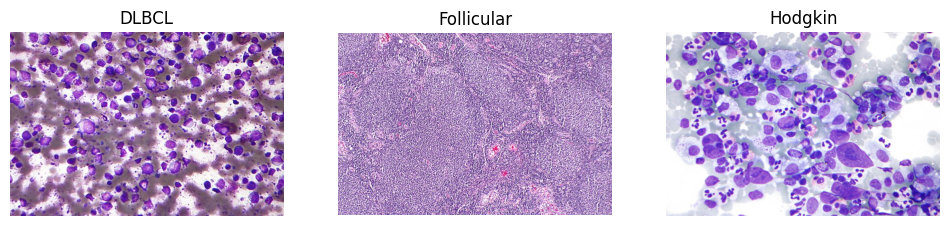

In [ ]:
image_paths = {
    "DLBCL": "/content/sample_dlbcl.jpg",
    "Follicular": "/content/sample_follicular.jpg",
    "Hodgkin": "/content/sample_hodgkin.png",
}

images = {k: Image.open(v) for k, v in image_paths.items()}

plt.figure(figsize=(12,4))
for i, (label, img) in enumerate(images.items()):
    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")
plt.show()

## 5. Using LLMs with Prompt Engineering

I have experimented with both the OpenAI ChatGPT model and the Google Gemini model to see whether they can determine if a histopathology image is from a lymphoma patient, and if so, which type of lymphoma it shows.

### Baseline Prompt

```text
What type of lymphoma is shown in this image?
```

❌ Problems:
- No guidance
- Encourages hallucination
- Unsafe medical framing

### Contrastive Prompt

In [ ]:
prompt_contrastive = '''
Compare the image against:
1. Diffuse Large B-Cell Lymphoma
2. Follicular Lymphoma
3. Hodgkin Lymphoma

For each category list supporting and conflicting evidence.
End with a disclaimer that this is not a diagnosis.
'''
print(prompt_contrastive)



Compare the image against:
1. Diffuse Large B-Cell Lymphoma
2. Follicular Lymphoma
3. Hodgkin Lymphoma

For each category list supporting and conflicting evidence.
End with a disclaimer that this is not a diagnosis.



## 6. CLIP + Customized Deep Neural Network Model

### 6.1 Zero-shot Learning with CLIP Model

I first feed a histopathology image directly into the CLIP model to determine the specific type of lymphoma it may represent. This approach involves:

- Converting the image of interest into an image-embedding vector using the CLIP model
- Converting text descriptions of the characteristics of each lymphoma subtype into text-embedding vectors, also using the CLIP model
- Computing the similarity between the image-embedding vector and each text-embedding vector
- Selecting the text-embedding vector with the highest similarity score to infer the lymphoma subtype shown in the image



In [ ]:
import clip

model_name = "ViT-L/14" #"ViT-B/32"
model, preprocess = clip.load(model_name, device="cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Check which device the model is on
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)


In [ ]:
image_input = preprocess(images["DLBCL"]).unsqueeze(0)
#image_input = preprocess(images["Follicular"]).unsqueeze(0)

# --- The change is here ---
with torch.no_grad():
    # Move the image to the same device as the model
    image_input = image_input.to(device)
    image_features = model.encode_image(image_input)


with torch.no_grad():
    image_features = model.encode_image(image_input)

In [ ]:
# text_prompts = [
#     "histopathology image of diffuse large B-cell lymphoma",
#     "histopathology image of follicular lymphoma",
#     "histopathology image of hodgkin lymphoma"
# ]

# text_prompts = [
#     "histopathology image showing diffuse sheets of large atypical lymphoid cells with prominent nucleoli (DLBCL)",
#     "histopathology image showing follicular architecture with nodular growth and small cleaved lymphocytes",
#     "histopathology image showing Reed-Sternberg cells in a mixed inflammatory background"
# ]

# text_prompts = [
#     "Histopathology images typically show a diffuse effacement of normal lymph node architecture, with sheets of large atypical lymphoid cells. The tumor cells often have vesicular nuclei, prominent nucleoli, and moderate to abundant cytoplasm, resulting in a relatively uniform population of large cells across the field.",
#     "Histopathology images commonly demonstrate a nodular or follicular architecture, with back-to-back abnormal follicles lacking normal polarization. The follicles are composed predominantly of small to medium-sized lymphoid cells with irregular, cleaved nuclei and scant cytoplasm, producing a relatively monotonous cellular appearance within each follicle.",
#     "Histopathology images characteristically show a sparse population of large atypical cells, including Reed–Sternberg–like cells, within a rich mixed inflammatory background. The background often includes small lymphocytes, eosinophils, histiocytes, and plasma cells, giving the tissue a heterogeneous and reactive appearance."
# ]

text_prompts = [
    "histopathology image showing diffuse sheets of large atypical lymphoid cells with vesicular chromatin, prominent nucleoli, and effacement of normal architecture, consistent with diffuse large B-cell lymphoma morphology",
    "histopathology image showing a nodular follicular growth pattern composed of small to medium lymphoid cells with irregular cleaved nuclei and relatively uniform follicles, consistent with follicular lymphoma morphology",
    "histopathology image showing scattered large Reed-Sternberg–like cells with prominent nucleoli in a mixed inflammatory background of lymphocytes and eosinophils, consistent with classical Hodgkin lymphoma morphology"
]

text_tokens = clip.tokenize(text_prompts)
with torch.no_grad():
  text_tokens = text_tokens.to(device)
  text_features = model.encode_text(text_tokens)

In [ ]:
similarity = (image_features @ text_features.T).softmax(dim=-1)

for label, score in zip(text_prompts, similarity[0]):
  print(label, float(score))

histopathology image showing diffuse sheets of large atypical lymphoid cells with vesicular chromatin, prominent nucleoli, and effacement of normal architecture, consistent with diffuse large B-cell lymphoma morphology 0.52197265625
histopathology image showing a nodular follicular growth pattern composed of small to medium lymphoid cells with irregular cleaved nuclei and relatively uniform follicles, consistent with follicular lymphoma morphology 0.24658203125
histopathology image showing scattered large Reed-Sternberg–like cells with prominent nucleoli in a mixed inflammatory background of lymphocytes and eosinophils, consistent with classical Hodgkin lymphoma morphology 0.2315673828125


In [ ]:
import torch
import clip
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report

# 1. Configuration
test_data_dir = '/content/drive/MyDrive/lymphoma_test_data'
classes = ["DLBCL", "Follicular", "Hodgkin"]
text_prompts = classes

device = "cuda" if torch.cuda.is_available() else "cpu"

# 2. Load Model using OpenAI CLIP library
model_name = "ViT-L/14"
model, preprocess = clip.load(model_name, device=device)

def evaluate_zero_shot(data_dir, prompts, classes):
    y_true = []
    y_pred = []

    # 3. Pre-encode text features
    text_tokens = clip.tokenize(prompts).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)

    # 4. Iterate through test folders
    for class_name in classes:
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            print(f"⚠️ Warning: Folder not found: {class_path}")
            continue

        print(f"Evaluating {class_name}...")
        files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff', 'webp'))]

        for img_name in tqdm(files):
            img_path = os.path.join(class_path, img_name)

            # Use CLIP's native preprocess function
            image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)

            with torch.no_grad():
                image_features = model.encode_image(image)
                image_features /= image_features.norm(dim=-1, keepdim=True)

                # Compute similarity
                similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
                pred_idx = torch.argmax(similarity, dim=-1).item()

            y_true.append(class_name)
            y_pred.append(prompts[pred_idx])

    # 5. Final check before reporting
    if len(y_true) == 0:
        print("❌ Error: No images were processed. Check your test_data_dir path and folder names.")
        return

    print("\nZERO-SHOT CLASSIFICATION REPORT")
    # Pass labels explicitly to ensure alignment
    print(classification_report(y_true, y_pred, labels=prompts, target_names=prompts, digits=4))

# Run the evaluation
evaluate_zero_shot(test_data_dir, text_prompts, classes)


Evaluating DLBCL...


100%|██████████| 40/40 [00:01<00:00, 24.67it/s]


Evaluating Follicular...


100%|██████████| 17/17 [00:00<00:00, 27.09it/s]


Evaluating Hodgkin...


100%|██████████| 35/35 [00:01<00:00, 19.53it/s]


ZERO-SHOT CLASSIFICATION REPORT
              precision    recall  f1-score   support

       DLBCL     0.5143    0.4500    0.4800        40
  Follicular     0.1930    0.6471    0.2973        17
     Hodgkin     0.0000    0.0000    0.0000        35

    accuracy                         0.3152        92
   macro avg     0.2358    0.3657    0.2591        92
weighted avg     0.2593    0.3152    0.2636        92




/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model, preprocess = clip.load("ViT-L/14", device=device)
# model.eval()

### 6.2 Few-shot Learning with CLIP Model

Next, I will leverage few-shot learning to improve image classification. The idea is to provide the CLIP model with several images from each category, allow it to learn the average pattern for each category, and then use these averaged patterns to classify a new image. This approach involves the following major steps:

- Converting the images in each category into image-embedding vectors using the CLIP model
- Computing the average image-embedding vector for each category
- Converting the image to be classified into an image-embedding vector using the CLIP model
- Computing the similarity between the input image's embedding vector and each category's average embedding vector
- Selecting the category whose average embedding vector has the highest similarity score to infer the lymphoma subtype of the input image


In [ ]:
def encode_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_input = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        features = model.encode_image(image_input)
        features /= features.norm(dim=-1, keepdim=True)

    return features.squeeze(0)  # shape: [512]

In [ ]:
def build_class_prototypes(data_dir):
    class_prototypes = {}

    for class_name in os.listdir(data_dir):

        # Skip hidden/system folders
        if class_name.startswith("."):
            continue

        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        embeddings = []

        for img_file in os.listdir(class_path):
            if not img_file.lower().endswith((".jpg", ".jpeg", ".png", ".tif", ".tiff", "webp")):
                continue

            img_path = os.path.join(class_path, img_file)
            embeddings.append(encode_image(img_path))

        if len(embeddings) == 0:
            print(f"❌ No valid images for class {class_name}, skipping.")
            continue

        prototype = torch.stack(embeddings).mean(dim=0)
        prototype /= prototype.norm()

        class_prototypes[class_name] = prototype
        print(f"✅ Built prototype for {class_name} ({len(embeddings)} images)")

    return class_prototypes


In [ ]:
prototypes = build_class_prototypes("/content/drive/MyDrive/few_shot_data")

✅ Built prototype for DLBCL (100 images)
✅ Built prototype for Follicular (60 images)
✅ Built prototype for Hodgkin (90 images)


In [ ]:
for cls in os.listdir("/content//drive/MyDrive/few_shot_data"):
    cls_path = os.path.join("/content//drive/MyDrive/few_shot_data", cls)
    if os.path.isdir(cls_path):
        print(cls, "→", os.listdir(cls_path))


DLBCL → ['image1.jpg', 'image2.jpg', 'image3.jpg', 'imgi_30_image.webp', 'imgi_28_image.webp', 'imgi_36_image.webp', 'imgi_32_image.webp', 'imgi_33_image.webp', 'imgi_27_image.webp', 'imgi_29_image.webp', 'imgi_26_image.webp', 'imgi_25_image.webp', 'imgi_31_image.webp', 'imgi_8_image.webp', 'imgi_18_image.webp', 'imgi_17_image.webp', 'imgi_16_image.webp', 'imgi_11_image.webp', 'imgi_10_image.webp', 'imgi_14_image.webp', 'imgi_15_image.webp', 'imgi_6_image.webp', 'imgi_12_image.webp', 'imgi_19_image.webp', 'imgi_13_image.webp', 'imgi_4_image.webp', 'imgi_9_image.webp', 'imgi_175_image.webp', 'imgi_165_image.webp', 'imgi_176_image.webp', 'imgi_7_image.webp', 'imgi_169_image.webp', 'imgi_5_image.webp', 'imgi_174_image.webp', 'imgi_180_image.webp', 'imgi_182_image.webp', 'imgi_181_image.webp', 'imgi_173_image.webp', 'imgi_166_image.webp', 'imgi_35_image.webp', 'imgi_3_image.webp', 'imgi_158_image.webp', 'imgi_159_image.webp', 'imgi_157_image.webp', 'imgi_171_image.webp', 'imgi_177_image.we

In [ ]:
print(prototypes.keys())

dict_keys(['DLBCL', 'Follicular', 'Hodgkin'])


In [ ]:
def classify_with_prototypes(image_path, prototypes):
    query_embedding = encode_image(image_path)

    scores = {}
    for class_name, prototype in prototypes.items():
        score = torch.dot(query_embedding, prototype).item()
        scores[class_name] = score

    return scores


In [ ]:
scores = classify_with_prototypes(
    "/content/sample_hodgkin.png",
    prototypes
)

for k, v in scores.items():
    print(f"{k}: {v:.4f}")


DLBCL: 0.8613
Follicular: 0.8599
Hodgkin: 0.8579


Evaluate the few-shot learning approach using CLIP model on all the test data.

In [ ]:
import torch
import os
from sklearn.metrics import classification_report, accuracy_score

def evaluate_prototypes(test_data_dir, prototypes):
    y_true = []
    y_pred = []

    # Get the list of classes from your prototypes
    valid_classes = list(prototypes.keys())

    print(f"Evaluating prototypes for classes: {valid_classes}")

    # Iterate through each folder in the test directory
    for class_name in os.listdir(test_data_dir):
        # 🚫 Skip hidden folders and files not in our prototype list
        if class_name.startswith(".") or class_name not in valid_classes:
            continue

        class_path = os.path.join(test_data_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        print(f"Testing folder: {class_name}...")

        for img_file in os.listdir(class_path):
            # Check for valid image extensions
            if not img_file.lower().endswith((".jpg", ".jpeg", ".png", ".tif", ".tiff", ".webp")):
                continue

            img_path = os.path.join(class_path, img_file)

            # 1. Get similarity scores using your previous function
            try:
                scores = classify_with_prototypes(img_path, prototypes)

                # 2. Pick the class with the highest score
                best_match = max(scores, key=scores.get)

                # 3. Store results
                y_true.append(class_name)
                y_pred.append(best_match)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")

    # 4. Compute Metrics
    print("\n" + "="*30)
    print("FEW-SHOT PERFORMANCE REPORT")
    print("="*30)
    print(classification_report(y_true, y_pred, target_names=valid_classes, digits=4))

    return y_true, y_pred

# --- EXECUTION ---
# Path to your test folder on Google Drive
test_path = '/content/drive/MyDrive/lymphoma_test_data'

# Run evaluation
true_labels, predicted_labels = evaluate_prototypes(test_path, prototypes)

Evaluating prototypes for classes: ['DLBCL', 'Follicular', 'Hodgkin']
Testing folder: DLBCL...
Testing folder: Follicular...
Testing folder: Hodgkin...

FEW-SHOT PERFORMANCE REPORT
              precision    recall  f1-score   support

       DLBCL     0.7750    0.7750    0.7750        40
  Follicular     0.5833    0.8235    0.6829        17
     Hodgkin     0.8214    0.6571    0.7302        35

    accuracy                         0.7391        92
   macro avg     0.7266    0.7519    0.7294        92
weighted avg     0.7572    0.7391    0.7409        92



In [ ]:
# # The following code shows how we could create more training samples by extracting patches from a training image
# # and encoding the image patches into image-embedding vectors

# import torchvision.transforms as T

# def encode_image_patches(image_path, patch_size=224, stride=224):
#     image = Image.open(image_path).convert("RGB")
#     w, h = image.size

#     embeddings = []

#     for y in range(0, h - patch_size + 1, stride):
#         for x in range(0, w - patch_size + 1, stride):
#             patch = image.crop((x, y, x + patch_size, y + patch_size))
#             patch_input = preprocess(patch).unsqueeze(0).to(device)

#             with torch.no_grad():
#                 emb = model.encode_image(patch_input)
#                 emb /= emb.norm(dim=-1, keepdim=True)

#             embeddings.append(emb.squeeze(0))

#     return torch.stack(embeddings).mean(dim=0)

### 6.3 Training a Deep Neural Network after CLIP Model

I further train a customized deep neural network after the CLIP model to better classify the histopathology images.

In this architecture, an image is first fed into the CLIP model, which converts it into an image‑embedding vector. That embedding vector is then passed to a deep neural network trained to identify informative signals within the embedding to improve image classification.

In [ ]:
# import torch
# import torch.nn as nn
# from transformers import CLIPModel, CLIPProcessor

# class CLIPClassifier(nn.Module):
#     def __init__(self, model_id, num_classes):
#         super(CLIPClassifier, self).__init__()
#         # Load the base CLIP model
#         self.clip_model = CLIPModel.from_pretrained(model_id)

#         # 1. Freeze CLIP weights to only train the new head (optional)
#         for param in self.clip_model.parameters():
#             param.requires_grad = False

#         # 2. Add a custom classification head (MLP)
#         # The hidden_size depends on the model (e.g., 512 for ViT-B/32)
#         embedding_dim = self.clip_model.config.projection_dim

#         self.classifier = nn.Sequential(
#             nn.Linear(embedding_dim, 256),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(256, num_classes)
#         )

#     def forward(self, pixel_values):
#         # Extract image embeddings from CLIP's vision encoder
#         # We use .get_image_features() for pre-projected embeddings
#         outputs = self.clip_model.get_image_features(pixel_values=pixel_values)

#         # Pass embeddings through our trainable classifier
#         return self.classifier(outputs)

# # Initialization
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model_id = "openai/clip-vit-base-patch32"
# model = CLIPClassifier(model_id, num_classes=10).to(device)
# processor = CLIPProcessor.from_pretrained(model_id)

In [ ]:
import torch
import torch.nn as nn
from transformers import CLIPModel, CLIPProcessor

class DeepCLIPClassifier(nn.Module):
    def __init__(self, model_id, num_classes):
        super(DeepCLIPClassifier, self).__init__()
        # Load the base CLIP model
        self.clip_model = CLIPModel.from_pretrained(model_id)

        # Freeze CLIP weights (transfer learning)
        for param in self.clip_model.parameters():
            param.requires_grad = False

        embedding_dim = self.clip_model.config.projection_dim

        # Deep Classification Head
        # Added Batch Normalization to help the deep layers converge faster
        self.classifier = nn.Sequential(
            # Layer 1: Expansion or projection
            nn.Linear(embedding_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),

            # Layer 2: Deep Processing
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            # Layer 3: Feature Compression
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            # Output Layer
            nn.Linear(256, num_classes)
        )

    def forward(self, pixel_values):
        # Extract the pre-projected embeddings from CLIP
        outputs = self.clip_model.get_image_features(pixel_values=pixel_values)

        # Ensure outputs are normalized if they aren't already
        outputs = outputs / outputs.norm(dim=-1, keepdim=True)

        return self.classifier(outputs)

# Initialization
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "openai/clip-vit-large-patch14"
model = DeepCLIPClassifier(model_id, num_classes=3).to(device)

processor = CLIPProcessor.from_pretrained(model_id)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


#### Training Workflow

To train this model on your own dataset, you would follow standard PyTorch training steps:

Prepare Data: Use a DataLoader to feed your labeled images through the CLIPProcessor.

Define Loss: Use `nn.CrossEntropyLoss()` for multi-class classification.

Optimize Head: Initialize an optimizer (like Adam) targeting only the parameters of the classifier head if you froze the CLIP base.

In [ ]:
!find . -type d -name ".ipynb_checkpoints" -exec rm -rf {} +

In [ ]:
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Path to the directory containing your 3 subfolders
data_root = "/content/drive/MyDrive/few_shot_data/"

# Define a transformation function that uses the CLIP processor
def clip_transform(image):
    # Returns the preprocessed pixel values as a tensor
    return processor(images=image, return_tensors="pt")['pixel_values'].squeeze(0)

# Define valid image extensions
valid_extensions = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

def is_valid_image(path):
    # Ignore hidden files/folders and only accept standard image extensions
    return not os.path.basename(path).startswith('.') and path.lower().endswith(valid_extensions)

# Create the dataset
dataset = ImageFolder(root=data_root, transform=clip_transform, is_valid_file=is_valid_image)

# Split into train and validation if needed
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

print(f"Classes found: {dataset.classes}") # Should be ['DLBCL', 'Follicular', 'Hodgkin']


Classes found: ['DLBCL', 'Follicular', 'Hodgkin']


In [ ]:
import torch.optim as optim

# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
# Only optimize the classifier head parameters
optimizer = optim.AdamW(model.classifier.parameters(), lr=1e-4, weight_decay=0.01)

num_epochs = 20

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        # Move data to device
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        # Note: model() calls the forward method we defined earlier
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")


Epoch [1/20] - Loss: 1.0423, Accuracy: 45.60%
Epoch [2/20] - Loss: 0.8349, Accuracy: 65.60%
Epoch [3/20] - Loss: 0.6619, Accuracy: 82.00%
Epoch [4/20] - Loss: 0.5633, Accuracy: 82.80%
Epoch [5/20] - Loss: 0.4585, Accuracy: 89.60%
Epoch [6/20] - Loss: 0.4209, Accuracy: 90.00%
Epoch [7/20] - Loss: 0.3482, Accuracy: 92.80%
Epoch [8/20] - Loss: 0.2835, Accuracy: 95.20%
Epoch [9/20] - Loss: 0.2371, Accuracy: 95.60%
Epoch [10/20] - Loss: 0.2259, Accuracy: 96.40%
Epoch [11/20] - Loss: 0.1980, Accuracy: 98.40%
Epoch [12/20] - Loss: 0.1934, Accuracy: 96.40%
Epoch [13/20] - Loss: 0.1580, Accuracy: 97.60%
Epoch [14/20] - Loss: 0.1383, Accuracy: 98.00%
Epoch [15/20] - Loss: 0.1288, Accuracy: 98.80%
Epoch [16/20] - Loss: 0.1042, Accuracy: 99.60%
Epoch [17/20] - Loss: 0.1294, Accuracy: 98.80%
Epoch [18/20] - Loss: 0.1365, Accuracy: 97.60%
Epoch [19/20] - Loss: 0.0835, Accuracy: 99.60%
Epoch [20/20] - Loss: 0.1156, Accuracy: 98.00%


#### Save the Trained Classifier

Once training is complete, save only the weights of the classifier head or the entire model.

In [ ]:
torch.save(model.state_dict(), 'lymphoma_clip_classifier.pth')
print("Model saved successfully.")

Model saved successfully.


#### Model Evalaution

To evaluate my model on the new test folder, I load my saved weights into the model architecture, set the model to evaluation mode, and iterate through the test data without calculating gradients.

In [ ]:
# 1. Initialize the architecture again
#model = CLIPClassifier(model_id="openai/clip-vit-base-patch32", num_classes=3).to(device)

# 2. Load the saved weights (state_dict)
model.load_state_dict(torch.load('lymphoma_clip_classifier.pth'))

# 3. CRITICAL: Set to evaluation mode
# This disables dropout and batch normalization behavior used during training
model.eval()


DeepCLIPClassifier(
  (clip_model): CLIPModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 768)
        (position_embedding): Embedding(77, 768)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=768, out_features=3072, bias=True)
              (fc2): Linear(in_features=3072, out_features=768, bi

#### Prepare the Test Data

Refer to my new folder path and create a DataLoader.

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report

test_data_root = '/content/drive/MyDrive/lymphoma_test_data'

# Use the same transform and filter used during training
test_dataset = ImageFolder(root=test_data_root, transform=clip_transform, is_valid_file=is_valid_image)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Testing on {len(test_dataset)} images across classes: {test_dataset.classes}")


Testing on 92 images across classes: ['DLBCL', 'Follicular', 'Hodgkin']


In [ ]:
# 1. Define your original class mapping manually
# This MUST match the order used during training (likely alphabetical)
target_classes = ['DLBCL', 'Follicular', 'Hodgkin']
class_to_idx = {cls: i for i, cls in enumerate(target_classes)}

# 2. Re-load the test dataset using the 'is_valid_file' filter
# and manually override the classes
test_dataset = ImageFolder(
    root='/content/drive/MyDrive/lymphoma_test_data',
    transform=clip_transform,
    is_valid_file=is_valid_image
)

# 3. OVERRIDE: Force the dataset to only use your 3 classes
# This filters out .ipynb_checkpoints or any extra folders
test_dataset.classes = target_classes
test_dataset.class_to_idx = class_to_idx

# Re-filter samples to ensure only images from those 3 folders are included
test_dataset.samples = [
    (path, class_to_idx[os.path.basename(os.path.dirname(path))])
    for path, _ in test_dataset.samples
    if os.path.basename(os.path.dirname(path)) in target_classes
]

# 4. Verify the labels are now only 0, 1, or 2
print(f"Verified Test Classes: {test_dataset.classes}")
print(f"Sample mapping: {test_dataset.samples[:3]}")

# 5. Now run your evaluation loop as before
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


Verified Test Classes: ['DLBCL', 'Follicular', 'Hodgkin']
Sample mapping: [('/content/drive/MyDrive/lymphoma_test_data/DLBCL/imgi_37_image.webp', 0), ('/content/drive/MyDrive/lymphoma_test_data/DLBCL/imgi_38_image.webp', 0), ('/content/drive/MyDrive/lymphoma_test_data/DLBCL/imgi_39_image.webp', 0)]


#### Run the Evaluation Loop

- `torch.no_grad()`: This prevents PyTorch from building a computational graph, which significantly reduces RAM usage during testing.

- classification_report: Since medical data can be imbalanced, accuracy alone isn't enough. This provides the F1-score and Recall for each specific lymphoma type.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Collect results for metrics
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate Accuracy
correct = (torch.tensor(all_preds) == torch.tensor(all_labels)).sum().item()
accuracy = 100 * correct / len(all_labels)

print(f"Test Accuracy: {accuracy:.2f}%")

# Detailed Report (Precision, Recall, F1-Score)
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes, digits=4))


Test Accuracy: 96.74%

Classification Report:
              precision    recall  f1-score   support

       DLBCL     1.0000    0.9500    0.9744        40
  Follicular     0.8947    1.0000    0.9444        17
     Hodgkin     0.9714    0.9714    0.9714        35

    accuracy                         0.9674        92
   macro avg     0.9554    0.9738    0.9634        92
weighted avg     0.9697    0.9674    0.9677        92

